In [1]:
import random
import torch
import json
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
import torch_directml
import matplotlib.pyplot as plt

In [2]:
def loadPrices(pricePath):
    with open(pricePath, "r") as priceFile:
        uuidToPrice = {}
        prices = json.load(priceFile)
        prices = prices['data']
        nonfoils = set() #Debug Sets
        foils = set()
        nones = set()
        for i in prices:
            if 'paper' in prices[i]:
                for vendor in prices[i]['paper']:
                    priced = False
                    for sellType in ['retail', 'buylist']:
                        if sellType in prices[i]['paper'][vendor]:
                            if 'normal' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['normal'].values())[-1]
                                nonfoils.add(i)
                                priced = True
                                break
                            elif 'foil' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['foil'].values())[-1]
                                foils.add(i)
                                priced = True
                                break
                            else:
                                print(f"No foil or nonfoil {i}")
                    if not priced:
                        nones.add(i)
        print(f"Loaded the Price of {len(uuidToPrice)}/{len(prices)} cards")
        return uuidToPrice

def loadCards(priceDict, cardPath):
    with open(cardPath, "r") as cardFile:
        uuidToCardData = {}
        data = json.load(cardFile)
        data = data['data']
        priceMisses = set()
        for i in data:
            if data[i]['language'] == 'English' and 'legalities' in data[i] and 'MOM' not in data[i]['printings'] and i in priceDict and len(data[i]['legalities']) != 0:
                uuidToCardData[i] = data[i]
            if i not in priceDict:
                priceMisses.add(i)
        print(f"Loaded data of {len(uuidToCardData)}/{len(data)} cards")
        return uuidToCardData

mtgCardsPath = "./AllIdentifiers.json"
mtgPricesPath = "./AllPrices.json"
uuidToPrice = loadPrices(mtgPricesPath)
uuidToCard = loadCards(uuidToPrice,mtgCardsPath)

Loaded the Price of 70801/79011 cards
Loaded data of 60987/84235 cards


In [3]:
def getOneHot(allClasses, classSubset):
    oneHot = [0] * len(allClasses)
    for c in classSubset:
        try:
            oneHot[allClasses.index(c)] = 1
        except:
            pass
    return oneHot

def prepareData(idToCard):
    # Supertype, subtype, legalities, keywords, artists (left to right 0 indexed)
    classCount = 8
    onehots = [set() for _ in range(classCount)]
    keywords = {}
    for uuid in idToCard:
        entry = idToCard[uuid]
        for t in entry.get('supertypes', []):
            onehots[enum['supertype']].add(t)
        for t in entry.get('subtypes', []):
            onehots[enum['subtype']].add(t)
        for l in entry.get('legalities', []):
            onehots[enum['legalities']].add(l)
        for k in entry.get('keywords', []):
            keywords[k] = keywords.get(k,0)
            keywords[k] += 1
            if keywords[k] > 1:
                onehots[enum['keywords']].add(k)
        if entry.get('artist'):
            onehots[enum['artist']].add(entry['artist'])
        for l in entry.get('printings', []):
            onehots[enum['printings']].add(l)
        for r in entry.get('rarity', None):
            if r is not None:
                onehots[enum['rarity']].add(r)
        for t in entry.get('flavorText',""):
            for word in t:
                onehots[enum['flavorText']].add(word)

    for s in onehots:
        globalOneHots.append(sorted(list(s)))
    
    globalOneHots.append(sorted(['X','U','B','R','G','W','C','P','S']))
    
                         
        
        
class CustomMTGDataset(Dataset):
    def __init__(self,uuidList):
        self.uuidList = uuidList
        self.ac = 0

    def __len__(self):
        return len(self.uuidList)
    #PROPOSED FEATURE VECTOR V 1
    # CMC (NUMBER)
    # NUMBER OF PIPS (ONE HOT BUT NOT ONE)
    # COLORS (ONE HOT)
    # PRINTINGS (NUMBER)
    # SUBTYPE (ONE HOT)
    # SUPERTYPE (ONE HOT)
    # LEGALITIES (ONE HOT)
    # KEYWORDS (ONE HOT)
    # ARTIST (ONE HOT) ?
    # RARITY (ONE HOT)
    # POWER (NUMBER)
    # TOUGHNESS (NUMBER)
    # LOYALTY (NUMBER)
    # FLAVOR TEXT LENGTH (NUMBER)
    # FLAVOR TEXT (ONE HOT)
    
    def __getitem__(self, idx):
#         self.ac += 1
#         print(self.ac)
        uuid = self.uuidList[idx]
        cardData = uuidToCard[uuid]
        featureVector = []
        phrexian = 0
        # Add 1, so that CMC of 0 is not ignored
        if 'convertedManaCost' in cardData:
            featureVector.append(int(cardData['convertedManaCost']) + 1)
        else:
            featureVector.append(0)
                         
        oneHotMana = [0] * len(globalOneHots[enum['pips']])
        colors = [0] * len(globalOneHots[enum['pips']])   
        if 'manaCost' in cardData:
            cost = cardData['manaCost']
            i = 0
            while(i < len(cost)):
                if(cost[i] == '/'):
                    cost = cost[:i] + "}{" + cost[i+1:]
                i += 1
            cost = cost.split("}")
            for i in range(len(cost)):
                cost[i] = cost[i].strip("{")
                if cost[i].isdigit() or cost[i] == '':
                    continue
                oneHotMana[globalOneHots[enum['pips']].index(cost[i])] += 1
                colors[globalOneHots[enum['pips']].index(cost[i])] = 1                     
        else:
            for i in cardData['colors']:
                colors[globalOneHots[enum['pips']].index(i)] = 1
            
        featureVector.extend(oneHotMana)
        featureVector.extend(colors)
        
        featureVector.append(len(cardData.get('printings',[])))
        
        featureVector.extend(getOneHot(globalOneHots[enum['printings']], cardData.get('printings',[])))
        
        featureVector.extend(getOneHot(globalOneHots[enum['subtype']], cardData.get('subtype',[])))
                                                      
        featureVector.extend(getOneHot(globalOneHots[enum['supertype']], cardData.get('supertype',[])))
        
        featureVector.extend(getOneHot(globalOneHots[enum['legalities']], cardData.get('legalities',[])))
                             
        featureVector.extend(getOneHot(globalOneHots[enum['keywords']], cardData.get('keywords',[])))
                             
        featureVector.extend(getOneHot(globalOneHots[enum['artist']], [cardData.get('artist')]))

        featureVector.extend(getOneHot(globalOneHots[enum['rarity']], [cardData.get('rarity')]))

        featureVector.extend(getOneHot(globalOneHots[enum['flavorText']], [cardData.get('flavorText')]))

        

                             
        cardPower = cardData.get('power', "0")
        if cardPower.isdigit():
            featureVector.append(int(cardPower))
            featureVector.append(0)
        else:
            featureVector.append(0)
            featureVector.append(1)
        
        
        cardToughness = cardData.get('toughness', "0")
        if cardToughness.isdigit():
            featureVector.append(int(cardToughness))
            featureVector.append(0)
        else:
            featureVector.append(0)
            featureVector.append(1)
        
        cardLoyalty = cardData.get('loyalty', "0")
        if cardLoyalty.isdigit():
            featureVector.append(int(cardLoyalty))
            featureVector.append(0)
        else:
            featureVector.append(0)
            featureVector.append(1)
            
#         print(featureVector)
        label = torch.tensor(float(uuidToPrice[uuid]))
        return np.array(featureVector, dtype="float32"), label


In [4]:
enum = {'supertype' : 0, 'subtype' : 1, 'legalities' : 2, 'keywords' : 3, 'artist' : 4,'printings' : 5,'rarity' : 6,'flavorText':7,'pips' : 8  }

globalOneHots = []
prepareData(uuidToCard)
allCards = list(uuidToCard.keys())
trainingDataPercent = 0.8
trainingIndex = int(len(allCards) * trainingDataPercent)
random.shuffle(allCards)

num_epochs = 10         # the number of epochs (each epoch: scanning the entire training set)
batch_size = 32        # how many samples are used in each iteration of SGD/Adam update
learning_rate = 0.01   # learning rate or step size used in gradient-based optimization algorithm

train_dataset = CustomMTGDataset(uuidList=allCards[:trainingIndex])

test_dataset = CustomMTGDataset(uuidList=allCards[trainingIndex:])

input_size = len(train_dataset.__getitem__(0)[0])       

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size,1) 
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.fc1(x)
        # out = self.relu(out)
        # out = self.fc2(out)
        return out

/home/foulgaze/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Step [1525/1525], Loss: 18702.4434
Accuracy of the network on the 12224 test cards: 36.7273323495655
Accuracy of the network on the training cards: 36.73983889811228
Epoch [2/10], Step [1525/1525], Loss: 570.6426
Accuracy of the network on the 12224 test cards: 31.833087391375635
Accuracy of the network on the training cards: 32.499128902006596
Epoch [3/10], Step [1525/1525], Loss: 254.2565
Accuracy of the network on the 12224 test cards: 43.31037875061485
Accuracy of the network on the training cards: 43.3724815019779
Epoch [4/10], Step [1525/1525], Loss: 359.2680
Accuracy of the network on the 12224 test cards: 36.145269716346945
Accuracy of the network on the training cards: 35.90768410912296
Epoch [5/10], Step [1525/1525], Loss: 319.2460
Accuracy of the network on the 12224 test cards: 39.588457124118705
Accuracy of the network on the training cards: 39.88603988603989
Epoch [6/10], Step [1525/1525], Loss: 1395.4435
Accuracy of the network on the 12224 test cards: 37.9

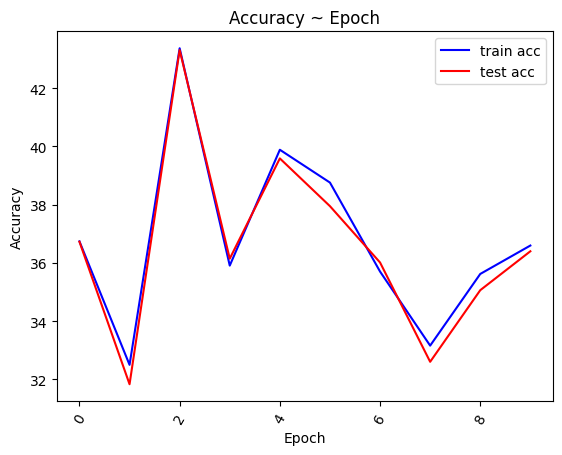

In [13]:
# device = torch_directml.device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(input_size).to(device)
# outputs = model(card)
threshold = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
# Train the model
train_acc_list, test_acc_list = [],[]
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i, (cards, labels) in enumerate(train_loader): 
#         print(len(card))
#         print(len(label))
        outputs = model(cards)
        loss = criterion(outputs, labels)
        
#         # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(i)
        if i == len(train_loader) - 1:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

#     # Test the model and plot training/testing accuracy
#     # In test phase, we don't need to compute gradients 
    with torch.no_grad():
        correct = 0
        total = 0
        for cards, labels in test_loader:
            outputs = model(cards)
            total += labels.size(0)
            correct += ((torch.abs(outputs - labels) / labels) <= threshold).sum().item()
#             correct += (outputs == labels).sum().item()

        print(f'Accuracy of the network on the {len(test_loader)*batch_size} test cards: {100 * correct / total}')
        test_acc_list.append(100 * correct / total)

        
    with torch.no_grad():
        correct = 0
        total = 0
        for cards, labels in train_loader:
            outputs = model(cards)
            total += labels.size(0)
#             correct += (outputs == labels).sum().item()
            correct += ((torch.abs(outputs - labels) / labels) <= threshold).sum().item()

        print(f'Accuracy of the network on the training cards: {100 * correct / total}')
        train_acc_list.append(100 * correct / total)
            
plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
        
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [22]:
model.fc1.weight[0]

tensor([ 0.9291, -0.3869, -0.6705,  ..., -1.3889, -0.6715, -2.6567],
       grad_fn=<SelectBackward0>)